In [80]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from wordcloud import WordCloud 
import jieba
%matplotlib inline

# plt.rcParams['font.sans-serif']=['SimHei'] #使 matplotilb 中文能正常顯示
fprop = fm.FontProperties(fname="SourceHanSansTW-Regular.otf")


# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

### 資料前處理

In [81]:
df = pd.read_csv("日旅資料.csv")
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date 
df.head()

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   
1          2  https://www.ptt.cc/bbs/Japan_Travel/M.16444013...   
2          3  https://www.ptt.cc/bbs/Japan_Travel/M.16444647...   
3          4  https://www.ptt.cc/bbs/Japan_Travel/M.16445446...   
4          5  https://www.ptt.cc/bbs/Japan_Travel/M.16445451...   

                  artTitle     artDate  artPoster   artCatagory  \
0         [住宿]關西W大阪(WHotel  2022-01-03  iPhone777  Japan_Travel   
1  [遊記]北海道8天7夜自駕遊(厚岸、星野等)下  2022-02-09  colon1114  Japan_Travel   
2   [住宿]星野磐梯山溫泉飯店，體驗時髦的大人感  2022-02-10      fussy  Japan_Travel   
3  [遊記]2021紅葉季的宇佐神宮，吃鱉火鍋料理  2022-02-11     peikie  Japan_Travel   
4  [遊記]大分縣豐後高田解憂雜貨店場景，住宿農泊  2022-02-11     peikie  Japan_Travel   

                                          artContent  \
0  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
1  時間：2019年6月\n\n主要城市：旭川、美瑛、北見、阿寒、釧路、帶廣、占冠村、札幌\n\...   
2  造訪日期：2019.03\n\n圖文版網誌\nhttps://natasha-travele...   
3  造訪日期：2021年11月\n\n圖文網誌版：\nhttps://peikie1.pixne...   
4  造訪日期：2021年12月初\n\n圖文網誌版：\nhttps://peikie1.pixn...   

                                          artComment            e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "skyangle0607...    14.8.132.225   
1  [{"cmtStatus": "→", "cmtPoster": "wingthink", ...  220.136.110.47   
2  [{"cmtStatus": "推", "cmtPoster": "kgcem", "cmt...   61.216.83.164   
3  [{"cmtStatus": "推", "cmtPoster": "mizuhara", "...   126.25.206.60   
4  [{"cmtStatus": "推", "cmtPoster": "lili999900",...   126.25.206.60   

          insertedDate dataSource  
0  2022-01-04 00:58:26        ptt  
1  2022-02-10 00:55:40        ptt  
2  2022-02-11 00:56:00        ptt  
3  2022-02-12 00:56:46        ptt  
4  2022-02-12 00:56:46        ptt

In [82]:
import csv
with open('日旅資料.csv','r',encoding='utf-8') as jp:
    countData =sum(1 for idx in csv.reader(jp))
print("共抓取{}筆資料".format(countData-1))

共抓取858筆資料


### 資料清理

In [83]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df

artUrl  \
0    https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   
1    https://www.ptt.cc/bbs/Japan_Travel/M.16444013...   
2    https://www.ptt.cc/bbs/Japan_Travel/M.16444647...   
3    https://www.ptt.cc/bbs/Japan_Travel/M.16445446...   
4    https://www.ptt.cc/bbs/Japan_Travel/M.16445451...   
..                                                 ...   
853  https://www.ptt.cc/bbs/Japan_Travel/M.17100632...   
854  https://www.ptt.cc/bbs/Japan_Travel/M.17100716...   
855  https://www.ptt.cc/bbs/Japan_Travel/M.17101146...   
856  https://www.ptt.cc/bbs/Japan_Travel/M.17101481...   
857  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...   

                    artTitle     artDate  \
0           [住宿]關西W大阪(WHotel  2022-01-03   
1    [遊記]北海道8天7夜自駕遊(厚岸、星野等)下  2022-02-09   
2     [住宿]星野磐梯山溫泉飯店，體驗時髦的大人感  2022-02-10   
3    [遊記]2021紅葉季的宇佐神宮，吃鱉火鍋料理  2022-02-11   
4    [遊記]大分縣豐後高田解憂雜貨店場景，住宿農泊  2022-02-11   
..                       ...         ...   
853             [遊記]對啊～是三重沒錯  2024-03-10   
854   [住宿]鹿兒島太陽皇家酒店可遠眺櫻島火山房型  2024-03-10   
855       [遊記]202401大阪名古屋7日遊  2024-03-11   
856       [遊記]熊本/黑川/湯布院/阿蘇6日  2024-03-11   
857        [遊記]三月_五日遊_岡山進關西出  2024-03-12   

                                            artContent  \
0    新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
1    時間：2019年6月\n\n主要城市：旭川、美瑛、北見、阿寒、釧路、帶廣、占冠村、札幌\n\...   
2    造訪日期：2019.03\n\n圖文版網誌\nhttps://natasha-travele...   
3    造訪日期：2021年11月\n\n圖文網誌版：\nhttps://peikie1.pixne...   
4    造訪日期：2021年12月初\n\n圖文網誌版：\nhttps://peikie1.pixn...   
..                                                 ...   
853  前言：\n出發前被問要去哪裡玩，不是露出困惑的臉，就是跟我說過橋就到了，僅有少少的人聽到\n...   
854  鹿兒島太陽皇家酒店Kagoshima Sun Royal Hotel\n地址:鹿児島県鹿児島...   
855  造訪日期：2024.01.10-01.16\n\n1/10\n搭乘 樂桃MM028 (桃園-...   
856  造訪日期：2024.2.18~2024.2.23\n\n\n2/18\n搭乘華航CI194到...   
857  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...   

                                              sentence  
0    新年快樂!!!。造訪日期：2121.11。從上回寫完佐渡懶人包之後可能精疲力竭，超久都沒碰b...  
1    時間：2019年6月。主要城市：旭川、美瑛、北見、阿寒、釧路、帶廣、占冠村、札幌。前情提要：...  
2    造訪日期：2019.03。圖文版網誌 in/out很便利。踏出飯店就能看到壯麗的磐梯山! i...  
3                                 造訪日期：2021年11月。圖文網誌版：  
4    造訪日期：2021年12月初。圖文網誌版： ロマン蔵（昭和的小鎮、昭和浪漫倉庫）・響（當地人...  
..                                                 ...  
853  前言：出發前被問要去哪裡玩，不是露出困惑的臉，就是跟我說過橋就到了，僅有少少的人聽到伊勢神宮...  
854  鹿兒島太陽皇家酒店Kagoshima Sun Royal Hotel地址:鹿児島県鹿児島市与...  
855  造訪日期：2024.01.10-01.16。1/10搭乘 樂桃MM028 (桃園-大阪關西）...  
856  造訪日期：2024.2.18~2024.2.23。2/18搭乘華航CI194到熊本。熊本的機...  
857  造訪日期: 2024年3月。先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅，此次...  

[858 rows x 5 columns]

### 斷句

In [84]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df

artUrl           artTitle  \
0      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
1      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
2      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
3      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
4      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
...                                                  ...                ...   
41932  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   
41933  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   
41934  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   
41935  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   
41936  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   

          artDate                                         artContent  \
0      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
1      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
2      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
3      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
4      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
...           ...                                                ...   
41932  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...   
41933  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...   
41934  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...   
41935  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...   
41936  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...   

                                      sentence  
0                                         新年快樂  
1                                 造訪日期：2121.11  
2                           從上回寫完佐渡懶人包之後可能精疲力竭  
3                                    超久都沒碰blog  
4      但想說為了維持乾淨版面 每年年費還是有在繳...加減也要output一下 XD  
...                                        ...  
41932                                  浴室該有的都有  
41933                                    穩定的東橫  
41934                這種價格(6000-6300日圓)我願意持續住東橫  
41935                                     謝謝觀看  
41936                                           

[41937 rows x 5 columns]

### 斷詞

In [85]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt

jieba.set_dictionary('dict.txt')
jieba.add_word('不要錯過',freq= 100)
jieba.add_word('不能錯過',freq= 100)

#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df

Building prefix dict from c:\Users\a8184\OneDrive\桌面\新增資料夾 (2)\W3 W4\dict.txt ...
Loading model from cache C:\Users\a8184\AppData\Local\Temp\jieba.u613ab0a74a0a712a12eddeffbd19122f.cache
Loading model cost 0.850 seconds.
Prefix dict has been built successfully.


artUrl           artTitle  \
0      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
1      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
2      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
3      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
4      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
...                                                  ...                ...   
41931  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   
41932  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   
41933  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   
41934  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   
41935  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   

          artDate                                         artContent  \
0      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
1      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
2      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
3      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
4      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
...           ...                                                ...   
41931  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...   
41932  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...   
41933  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...   
41934  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...   
41935  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...   

                                   sentence  
0                                      新年快樂  
1                                造訪日期212111  
2                        從上回寫完佐渡懶人包之後可能精疲力竭  
3                                 超久都沒碰blog  
4      但想說為了維持乾淨版面 每年年費還是有在繳加減也要output一下 XD  
...                                     ...  
41931              有除臭劑每一間我都拿來噴XDTV有8台左右可以看  
41932                               浴室該有的都有  
41933                                 穩定的東橫  
41934                這種價格60006300日圓我願意持續住東橫  
41935                                  謝謝觀看  

[41412 rows x 5 columns]

In [86]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df

artUrl           artTitle  \
0      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
0      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
1      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
1      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
1      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
...                                                  ...                ...   
41934  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   
41934  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   
41934  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   
41935  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   
41935  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   

          artDate                                         artContent    word  
0      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...      新年  
0      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...      快樂  
1      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...      造訪  
1      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...      日期  
1      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...  212111  
...           ...                                                ...     ...  
41934  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...      願意  
41934  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...      持續  
41934  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...      東橫  
41935  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...      謝謝  
41935  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...      觀看  

[235176 rows x 5 columns]

### 移除停用字

In [87]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8').readlines()] 
stopwords_manual = ["in", "一下", "一位", "一個", "一直", "一點", "下午", "不用", "主要", "之後", "今天", "今年", "今日", "他們", "以下", "以後", "使用", "來到", "入住", "內容", "出發", "分享", "前往", "包含", "包括", "可能", "吃到", "各位", "名稱", "回到", "因一", "因上", "地方", "好像", "完整", "就是", "層面", "左右", "年前", "年增", "建議", "感覺", "成為", "我們", "打打", "抵達", "持續", "指出", "提供", "搭配", "整個", "方面", "旁邊", "日期", "早上", "明天", "明年", "明日", "昨日", "是否", "晚上", "最後", "月底", "有", "有沒有", "有無", "東西", "決定", "沒", "沒有", "準備", "然後", "特別", "現在", "發現", "發生", "目前", "直接", "相關", "看到", "看看", "知道", "碰到", "維持", "聞到", "聽到", "表示", "裡面", "認為", "謝謝", "這", "這裡", "這間", "造成", "造訪", "進行", "過去", "那裡", "附近", "隔天", "離開", "需要", "顯示"]
stopwords.extend(stopwords_manual)

In [88]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df

artUrl           artTitle  \
0      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
0      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
1      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
2      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
2      https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   [住宿]關西W大阪(WHotel   
...                                                  ...                ...   
41934  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   
41934  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   
41934  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   
41934  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   
41935  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  [遊記]三月_五日遊_岡山進關西出   

          artDate                                         artContent      word  
0      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...        新年  
0      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...        快樂  
1      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...    212111  
2      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...        寫完  
2      2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...        佐渡  
...           ...                                                ...       ...  
41934  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...  60006300  
41934  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...        日圓  
41934  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...        願意  
41934  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...        東橫  
41935  2024-03-12  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...        觀看  

[186720 rows x 5 columns]

# <font color=#ffa >從這裡開始</font>  
## Lexicon-based 情緒分析  
<font color=#ffa>資料集狀態noStop_df：已完成清理、斷句、斷詞、去除停用字</font>

### 準備 LIWC 字典

In [89]:
# 讀取情緒字典
liwc_dict = pd.read_csv("LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

word sentiments
0   ):     affect
1   3q     affect
2   :(     affect
3   :)     affect
4   <3     affect

In [90]:
liwc_dict['sentiments'].describe()

count       4682
unique         6
top       affect
freq        2061
Name: sentiments, dtype: object

### 情緒字典與斷詞結果進行合併

In [91]:
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df

artUrl     artDate  \
0       https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  2022-01-03   
1       https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  2022-01-03   
2       https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  2022-01-03   
3       https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  2022-01-03   
4       https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  2022-01-03   
...                                                   ...         ...   
195920  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  2024-03-12   
195921  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  2024-03-12   
195922  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  2024-03-12   
195923  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  2024-03-12   
195924  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...  2024-03-12   

                 artTitle                                         artContent  \
0        [住宿]關西W大阪(WHotel  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
1        [住宿]關西W大阪(WHotel  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
2        [住宿]關西W大阪(WHotel  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
3        [住宿]關西W大阪(WHotel  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
4        [住宿]關西W大阪(WHotel  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
...                   ...                                                ...   
195920  [遊記]三月_五日遊_岡山進關西出  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...   
195921  [遊記]三月_五日遊_岡山進關西出  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...   
195922  [遊記]三月_五日遊_岡山進關西出  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...   
195923  [遊記]三月_五日遊_岡山進關西出  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...   
195924  [遊記]三月_五日遊_岡山進關西出  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...   

          word sentiments  
0           新年        NaN  
1           快樂     affect  
2           快樂   positive  
3       212111        NaN  
4           寫完        NaN  
...        ...        ...  
195920      日圓        NaN  
195921      願意     affect  
195922      願意   positive  
195923      東橫        NaN  
195924      觀看        NaN  

[195925 rows x 6 columns]

### 正負向情緒詞彙頻率折線圖圖


In [92]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

artDate sentiments  size
1     2022-01-03   negative     1
2     2022-01-03   positive    12
4     2022-02-09   negative     1
5     2022-02-09   positive     8
8     2022-02-10   negative     1
...          ...        ...   ...
1487  2024-03-10   negative     5
1488  2024-03-10   positive    11
1493  2024-03-11   positive    17
1492  2024-03-11   negative     4
1496  2024-03-12   positive    18

[695 rows x 3 columns]

<font color=#ffa>2022之前的正負情緒樣本數少，推測可能是疫情影響導致旅遊人口減少</font>

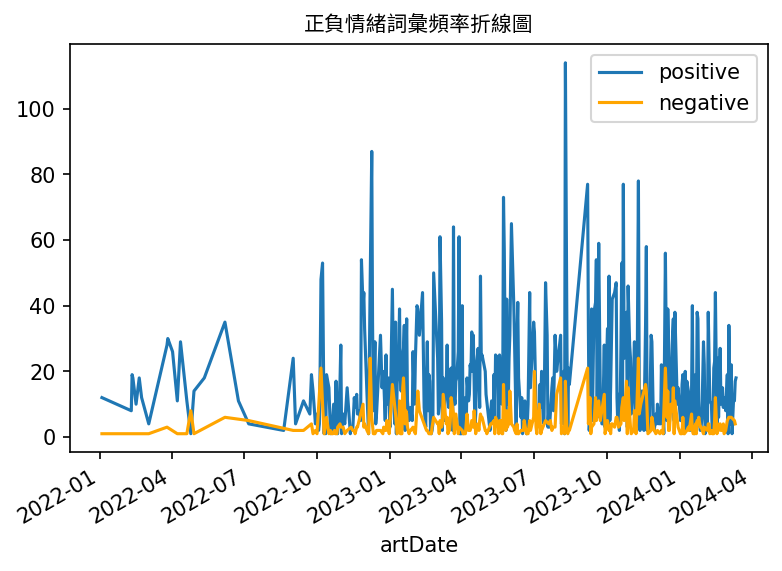

In [93]:
colors = ['tab:blue', "orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

### rolling average（滾動平均  
* 去除瞬間噪聲： 情緒數據可能受到瞬間事件或噪聲的影響，例如突發的大量評論或新聞。滾動平均有助於平滑這些突變，使你更容易觀察到整體趨勢。
* 強調長期趨勢： 滾動平均有助於強調長期情緒趨勢，而不受短期波動的干擾。這對於觀察情緒的漸變和長期變化非常有用。  
<font color=#ffa>(14天平均)</font>



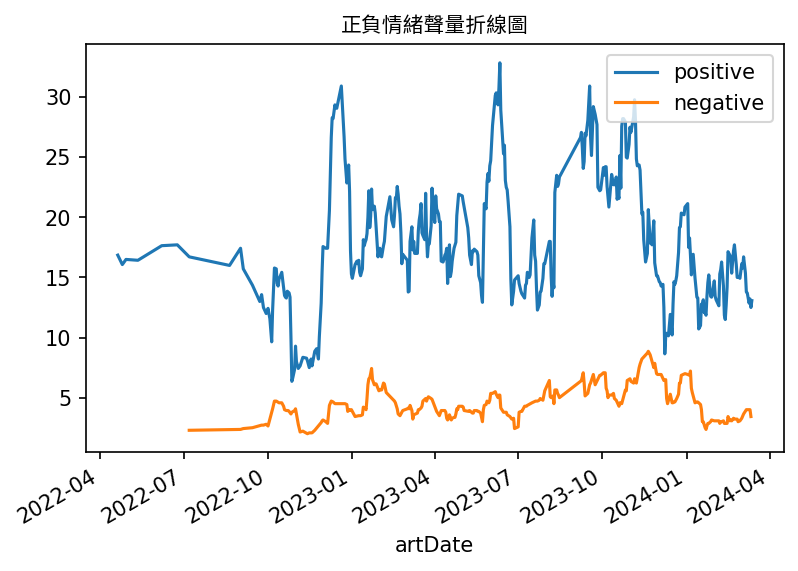

In [94]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

正面詞彙幾乎每天都超過負面，是個和諧的討論板

### 正負向情緒詞彙比例折線圖圖

In [95]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

artDate sentiments  size     ratio
1     2022-01-03   negative     1  0.076923
2     2022-01-03   positive    12  0.923077
4     2022-02-09   negative     1  0.111111
5     2022-02-09   positive     8  0.888889
8     2022-02-10   negative     1  0.050000
...          ...        ...   ...       ...
1487  2024-03-10   negative     5  0.312500
1488  2024-03-10   positive    11  0.687500
1493  2024-03-11   positive    17  0.809524
1492  2024-03-11   negative     4  0.190476
1496  2024-03-12   positive    18  1.000000

[695 rows x 4 columns]

In [96]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

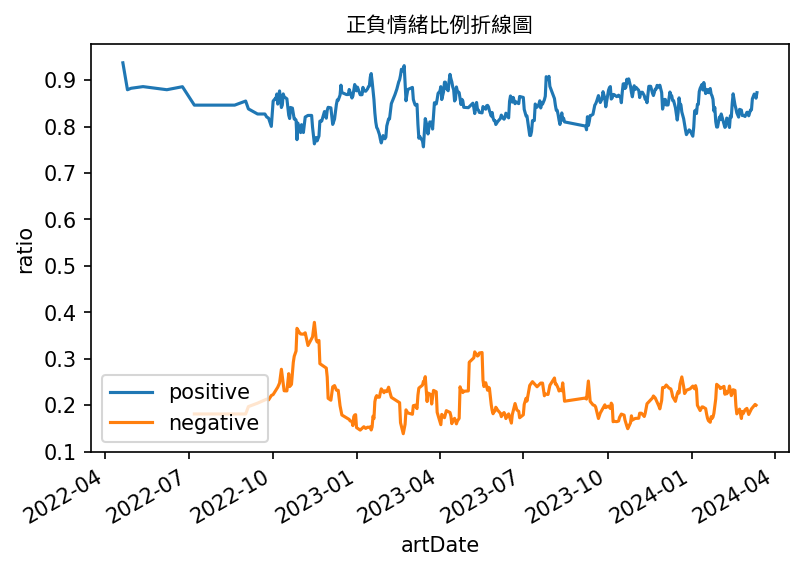

In [97]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

### 正負向情緒分數折線圖

In [98]:
sentiment_count

artDate sentiments  size     ratio
1     2022-01-03   negative     1  0.076923
2     2022-01-03   positive    12  0.923077
4     2022-02-09   negative     1  0.111111
5     2022-02-09   positive     8  0.888889
8     2022-02-10   negative     1  0.050000
...          ...        ...   ...       ...
1487  2024-03-10   negative     5  0.312500
1488  2024-03-10   positive    11  0.687500
1493  2024-03-11   positive    17  0.809524
1492  2024-03-11   negative     4  0.190476
1496  2024-03-12   positive    18  1.000000

[695 rows x 4 columns]

In [99]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size",aggfunc="sum", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

artDate  negative  positive
0  2022-01-03         1        12
1  2022-02-09         1         8
2  2022-02-10         1        19
3  2022-02-11         1        18
4  2022-02-15         1        10

In [100]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

artDate  negative  positive  sentiment_value
0  2022-01-03         1        12               11
1  2022-02-09         1         8                7
2  2022-02-10         1        19               18
3  2022-02-11         1        18               17
4  2022-02-15         1        10                9

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

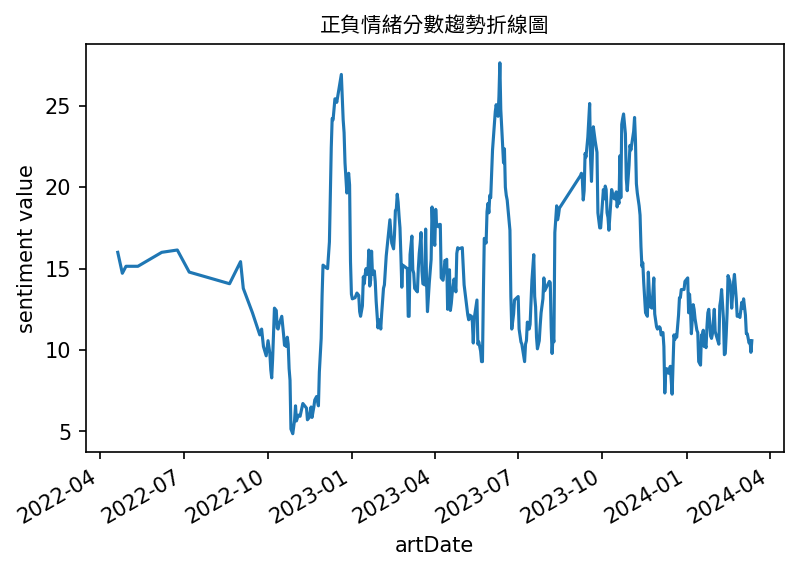

In [101]:
fig, ax = plt.subplots()
rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

<font color=#ffa>（題外）2022年10月～12月包含了一個低谷和高峰，rolling_days改為7天並放大區間來看：  
   發現11月的情緒分數偏低，高峰在12月中附近</font>

Text(0.5, 1.0, '2022年10~12月情緒分數')

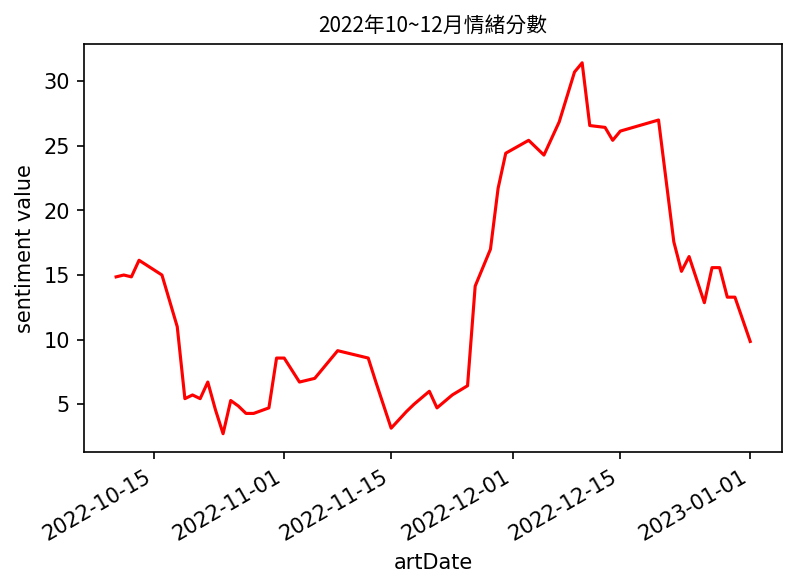

In [102]:
fig, ax = plt.subplots()

ptt_sentiment_value['artDate'] = pd.to_datetime(ptt_sentiment_value['artDate'])

# 定義滾動平均的天數
rolling_days = 7

# 篩選指定日期範圍內的數據
filtered_df = ptt_sentiment_value[(ptt_sentiment_value['artDate'] >= '2022-10') & (ptt_sentiment_value['artDate'] <= '2023-01')]
ax.plot(filtered_df["artDate"], filtered_df["sentiment_value"].rolling(rolling_days).mean(),color='red')
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("2022年10~12月情緒分數", fontproperties=fprop)

### 文章為單位情緒分析

In [103]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article

artUrl sentiments  size
0     https://www.ptt.cc/bbs/Japan_Travel/M.16411981...     affect    13
1     https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   negative     1
2     https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   positive    12
3     https://www.ptt.cc/bbs/Japan_Travel/M.16444013...     affect     9
4     https://www.ptt.cc/bbs/Japan_Travel/M.16444013...   negative     1
...                                                 ...        ...   ...
2421  https://www.ptt.cc/bbs/Japan_Travel/M.17101481...   negative     4
2422  https://www.ptt.cc/bbs/Japan_Travel/M.17101481...   positive    17
2423  https://www.ptt.cc/bbs/Japan_Travel/M.17101481...        sad     3
2424  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...     affect    18
2425  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...   positive    18

[2426 rows x 3 columns]

In [104]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

artUrl  affect  anger  anx  \
0  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...    13.0    0.0  0.0   
1  https://www.ptt.cc/bbs/Japan_Travel/M.16444013...     9.0    0.0  0.0   
2  https://www.ptt.cc/bbs/Japan_Travel/M.16444647...    20.0    0.0  1.0   
3  https://www.ptt.cc/bbs/Japan_Travel/M.16445451...    19.0    0.0  1.0   
4  https://www.ptt.cc/bbs/Japan_Travel/M.16448960...    11.0    0.0  1.0   

   negative  positive  sad  
0       1.0      12.0  0.0  
1       1.0       8.0  0.0  
2       1.0      19.0  0.0  
3       1.0      18.0  0.0  
4       1.0      10.0  0.0

In [105]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

artUrl  affect  anger  anx  \
0  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...    13.0    0.0  0.0   
1  https://www.ptt.cc/bbs/Japan_Travel/M.16444013...     9.0    0.0  0.0   
2  https://www.ptt.cc/bbs/Japan_Travel/M.16444647...    20.0    0.0  1.0   
3  https://www.ptt.cc/bbs/Japan_Travel/M.16445451...    19.0    0.0  1.0   
4  https://www.ptt.cc/bbs/Japan_Travel/M.16448960...    11.0    0.0  1.0   

   negative  positive  sad  sentiment_value  
0       1.0      12.0  0.0             11.0  
1       1.0       8.0  0.0              7.0  
2       1.0      19.0  0.0             18.0  
3       1.0      18.0  0.0             17.0  
4       1.0      10.0  0.0              9.0

In [106]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article

artUrl  affect  anger  anx  \
0    https://www.ptt.cc/bbs/Japan_Travel/M.16411981...    13.0    0.0  0.0   
1    https://www.ptt.cc/bbs/Japan_Travel/M.16444013...     9.0    0.0  0.0   
2    https://www.ptt.cc/bbs/Japan_Travel/M.16444647...    20.0    0.0  1.0   
3    https://www.ptt.cc/bbs/Japan_Travel/M.16445451...    19.0    0.0  1.0   
4    https://www.ptt.cc/bbs/Japan_Travel/M.16448960...    11.0    0.0  1.0   
..                                                 ...     ...    ...  ...   
759  https://www.ptt.cc/bbs/Japan_Travel/M.17100592...     8.0    0.0  0.0   
760  https://www.ptt.cc/bbs/Japan_Travel/M.17100632...     5.0    0.0  2.0   
761  https://www.ptt.cc/bbs/Japan_Travel/M.17100716...     3.0    0.0  0.0   
762  https://www.ptt.cc/bbs/Japan_Travel/M.17101481...    22.0    0.0  1.0   
763  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...    18.0    0.0  0.0   

     negative  positive  sad  sentiment_value sentiment_class  
0         1.0      12.0  0.0             11.0              正向  
1         1.0       8.0  0.0              7.0              正向  
2         1.0      19.0  0.0             18.0              正向  
3         1.0      18.0  0.0             17.0              正向  
4         1.0      10.0  0.0              9.0              正向  
..        ...       ...  ...              ...             ...  
759       0.0       8.0  0.0              8.0              正向  
760       3.0       1.0  1.0             -2.0              負向  
761       2.0       1.0  0.0             -1.0              負向  
762       4.0      17.0  3.0             13.0              正向  
763       0.0      18.0  0.0             18.0              正向  

[764 rows x 9 columns]

In [107]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date
clear_df_sentiment

system_id                                             artUrl  \
0            1  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...   
1            2  https://www.ptt.cc/bbs/Japan_Travel/M.16444013...   
2            3  https://www.ptt.cc/bbs/Japan_Travel/M.16444647...   
3            4  https://www.ptt.cc/bbs/Japan_Travel/M.16445446...   
4            5  https://www.ptt.cc/bbs/Japan_Travel/M.16445451...   
..         ...                                                ...   
853        854  https://www.ptt.cc/bbs/Japan_Travel/M.17100632...   
854        855  https://www.ptt.cc/bbs/Japan_Travel/M.17100716...   
855        856  https://www.ptt.cc/bbs/Japan_Travel/M.17101146...   
856        857  https://www.ptt.cc/bbs/Japan_Travel/M.17101481...   
857        858  https://www.ptt.cc/bbs/Japan_Travel/M.17102305...   

                    artTitle     artDate   artPoster   artCatagory  \
0           [住宿]關西W大阪(WHotel  2022-01-03   iPhone777  Japan_Travel   
1    [遊記]北海道8天7夜自駕遊(厚岸、星野等)下  2022-02-09   colon1114  Japan_Travel   
2     [住宿]星野磐梯山溫泉飯店，體驗時髦的大人感  2022-02-10       fussy  Japan_Travel   
3    [遊記]2021紅葉季的宇佐神宮，吃鱉火鍋料理  2022-02-11      peikie  Japan_Travel   
4    [遊記]大分縣豐後高田解憂雜貨店場景，住宿農泊  2022-02-11      peikie  Japan_Travel   
..                       ...         ...         ...           ...   
853             [遊記]對啊～是三重沒錯  2024-03-10    lydiawei  Japan_Travel   
854   [住宿]鹿兒島太陽皇家酒店可遠眺櫻島火山房型  2024-03-10  lumike0602  Japan_Travel   
855       [遊記]202401大阪名古屋7日遊  2024-03-11      yoyigh  Japan_Travel   
856       [遊記]熊本/黑川/湯布院/阿蘇6日  2024-03-11    terryaxl  Japan_Travel   
857        [遊記]三月_五日遊_岡山進關西出  2024-03-12    SoulFire  Japan_Travel   

                                            artContent  \
0    新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
1    時間：2019年6月\n\n主要城市：旭川、美瑛、北見、阿寒、釧路、帶廣、占冠村、札幌\n\...   
2    造訪日期：2019.03\n\n圖文版網誌\nhttps://natasha-travele...   
3    造訪日期：2021年11月\n\n圖文網誌版：\nhttps://peikie1.pixne...   
4    造訪日期：2021年12月初\n\n圖文網誌版：\nhttps://peikie1.pixn...   
..                                                 ...   
853  前言：\n出發前被問要去哪裡玩，不是露出困惑的臉，就是跟我說過橋就到了，僅有少少的人聽到\n...   
854  鹿兒島太陽皇家酒店Kagoshima Sun Royal Hotel\n地址:鹿児島県鹿児島...   
855  造訪日期：2024.01.10-01.16\n\n1/10\n搭乘 樂桃MM028 (桃園-...   
856  造訪日期：2024.2.18~2024.2.23\n\n\n2/18\n搭乘華航CI194到...   
857  造訪日期: 2024年3月\n\n先下結語：第一次去日本東京是朋友一起，這次是單人背包客獨旅...   

                                            artComment             e_ip  \
0    [{"cmtStatus": "推", "cmtPoster": "skyangle0607...     14.8.132.225   
1    [{"cmtStatus": "→", "cmtPoster": "wingthink", ...   220.136.110.47   
2    [{"cmtStatus": "推", "cmtPoster": "kgcem", "cmt...    61.216.83.164   
3    [{"cmtStatus": "推", "cmtPoster": "mizuhara", "...    126.25.206.60   
4    [{"cmtStatus": "推", "cmtPoster": "lili999900",...    126.25.206.60   
..                                                 ...              ...   
853  [{"cmtStatus": "推", "cmtPoster": "zombierosa",...   150.117.158.38   
854                                                 []   125.228.145.90   
855  [{"cmtStatus": "推", "cmtPoster": "fang37564", ...     111.83.76.50   
856  [{"cmtStatus": "推", "cmtPoster": "chipndalepp"...  111.251.240.217   
857  [{"cmtStatus": "推", "cmtPoster": "AtDe", "cmtC...    49.216.175.34   

            insertedDate dataSource sentiment_class  
0    2022-01-04 00:58:26        ptt              正向  
1    2022-02-10 00:55:40        ptt              正向  
2    2022-02-11 00:56:00        ptt              正向  
3    2022-02-12 00:56:46        ptt             NaN  
4    2022-02-12 00:56:46        ptt              正向  
..                   ...        ...             ...  
853  2024-03-11 02:11:23        ptt              負向  
854  2024-03-11 02:11:23        ptt              負向  
855  2024-03-13 02:06:25        ptt             NaN  
856  2024-03-13 02:06:25        ptt              正向  
857  2024-03-13 02:06:28        ptt              正向  

[858 rows x 12 columns]

In [108]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

artDate sentiment_class  size
0    2022-01-03              正向     1
1    2022-02-09              正向     1
2    2022-02-10              正向     1
3    2022-02-11              正向     1
4    2022-02-15              正向     1
..          ...             ...   ...
451  2024-03-09              正向     1
452  2024-03-10              正向     2
453  2024-03-10              負向     2
454  2024-03-11              正向     1
455  2024-03-12              正向     1

[456 rows x 3 columns]

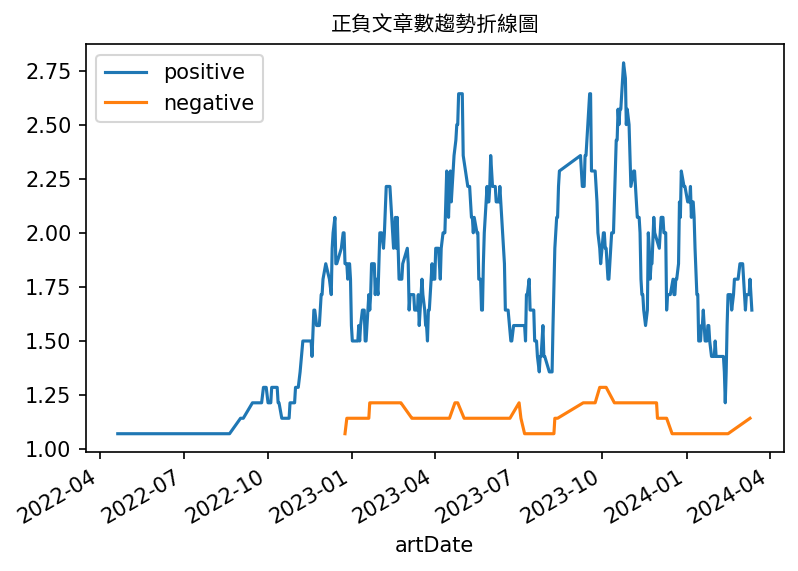

In [109]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper left")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

### 情緒代表字

In [110]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

word sentiments  size
49      不錯     affect   408
50      不錯   positive   408
368     好吃     affect   349
369     好吃   positive   349
279     喜歡   positive   340
...    ...        ...   ...
997     獎品     affect     1
998     獎品   positive     1
999     獎金     affect     1
1000    獎金   positive     1
0     love     affect     1

[1506 rows x 3 columns]

In [111]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

word sentiments  size
50     不錯   positive   408
369    好吃   positive   349
279    喜歡   positive   340
147    免費   positive   303
1133   簡單   positive   202
810    朋友   positive   184
467    希望   positive   181
1231   舒適   positive   170
1229   舒服   positive   164
1370   適合   positive   156
1398   開心   positive   138
70     享受   positive   119
103    值得   positive   119
825    樂園   positive   109
1184   美味   positive   109

In [112]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

word sentiments  size
738    擔心   negative    69
1178   缺點   negative    55
759    放棄   negative    42
1424   隨便   negative    37
1503   麻煩   negative    34
1391   錯過   negative    27
994    猶豫   negative    26
353    失望   negative    25
715    控制   negative    21
516    後悔   negative    21
44     不足   negative    20
305    困難   negative    20
1096   禁止   negative    20
1197   老舊   negative    18
1378   遺憾   negative    18

<font color=#ffa>還是有不少待清除的情緒詞  
ex. 正向： 免費、朋友、樂園  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;負向： 擔心、隨便、控制</font>

C:\Users\a8184\AppData\Local\Temp\ipykernel_20016\391454114.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\a8184\AppData\Local\Temp\ipykernel_20016\391454114.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

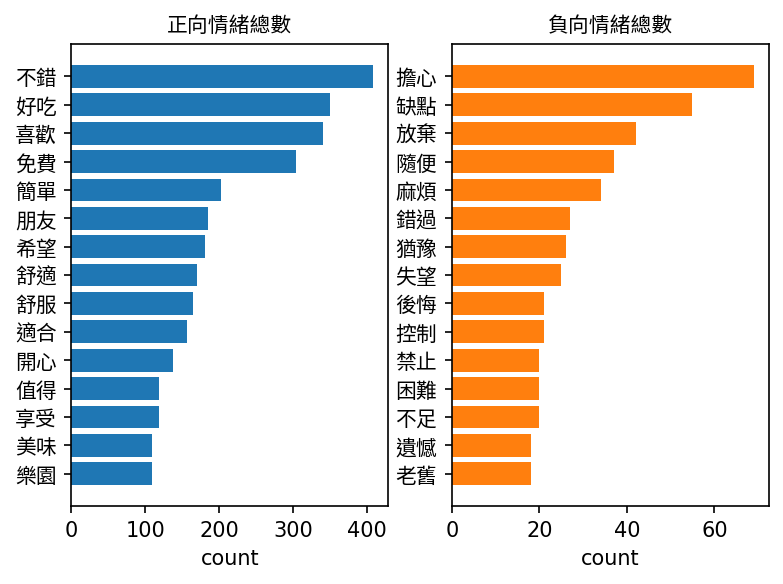

In [113]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

### 檢查情緒是否符合文本

In [114]:
filtered_df = sent_df[sent_df['sentence'].str.contains('控制', na=False)]
filtered_df.head()

artUrl  \
7765   https://www.ptt.cc/bbs/Japan_Travel/M.16723244...   
10542  https://www.ptt.cc/bbs/Japan_Travel/M.16743052...   
10544  https://www.ptt.cc/bbs/Japan_Travel/M.16743052...   
10547  https://www.ptt.cc/bbs/Japan_Travel/M.16743052...   
10548  https://www.ptt.cc/bbs/Japan_Travel/M.16743052...   

                              artTitle     artDate  \
7765   [住宿]京都帕貢M's飯店HotelPagongwithM's  2022-12-29   
10542                  [住宿]東京六本木三井花園飯店  2023-01-21   
10544                  [住宿]東京六本木三井花園飯店  2023-01-21   
10547                  [住宿]東京六本木三井花園飯店  2023-01-21   
10548                  [住宿]東京六本木三井花園飯店  2023-01-21   

                                              artContent              sentence  
7765   網誌版\nhttps://haruhii.pixnet.net/blog/post/4850...               中央有燈光控制  
10542  造訪日期：2023.01\n全圖文：\nhttps://www.sisiwander.com...      可以控制屋內每區的燈光和全室空調  
10544  造訪日期：2023.01\n全圖文：\nhttps://www.sisiwander.com...  也可以在這裡控制門外請不要打擾的號誌顯示  
10547  造訪日期：2023.01\n全圖文：\nhttps://www.sisiwander.com...     也可以單獨控制入口房間床閱讀燈腳光  
10548  造訪日期：2023.01\n全圖文：\nhttps://www.sisiwander.com...                  分區控制

In [115]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

中央有燈光控制
可以控制屋內每區的燈光和全室空調
也可以在這裡控制門外請不要打擾的號誌顯示
也可以單獨控制入口房間床閱讀燈腳光
分區控制
床頭的按鈕可以控制整間房間的燈光
後樂園的池子居然是有溫度控制
房間內燈光基本都是以兩床中央的控制面板操作設有兩個插座跟兩個USB插座房間四處也還有更多充電的插座很夠用
兩張床邊都有能調節房內燈光的控制鈕
空調控制則設置在牆面上
 我加點了霜淇淋 本來想葡萄跟梨子都點的但今天前面已經吃了兩支 考量到熱量控制等明天再去其他地方找桃子霜淇淋 一個200 好吃 背包周邊我是把它綁在我自己的背包上 這邊不能拍照 可google自行參考可惜天氣不好 看不到富士山 然後水溫有一點低 沒有說很熱這邊特色是營業時間很長 早上四點就可以 來看日出  然後真的不少刺青的客人 喝牛奶這個動畫好像沒有就是了 她們是泡完才去吃東西然後已經天色開始變黑了 準備往撫子拍照片給凜的地方出發 拍不出什麼好照片 就盡量調整 傷眼就sorry了真實的露營場走到這邊 大概要兩公里特別那種夜路沒25分鐘到不了只能說 撫子對凜這不是真愛 什麼才是真愛XDD 但看完夜景已經沒巴士了只好摸黑回家真的暗小危險 然後放一張我行李箱的露營貼紙有貼真的差很多 這幾次行李一出來就可以注意到XD 去程慢慢走有逛公園去露營場迷路大概佔了10公里以她們裝備要這樣走還是搭公車好了 一來是圖多還是分開的好二來 明天本來只預定去甲斐常葉站 內船 身延等等畢竟對真正露營還好露營地幾乎沒車都去不了但想到第一集的場景真的好想去啊
中間有個空調控制器
是用插卡的方式來控制
因為兩個人都被食物控制
是希望能透過預算控制
浴室真的是非常熟悉的Super Hotel難以轉身尺寸水龍頭也是淋浴跟水槽共用一個控制閥
全速域主動車距控制
附近有Aeon優點使用平板控制房間設定
具有優化之後的DRCC 動態雷達巡航控制系統
 估計可以至少把3個29吋行李箱同時打開攤平還有餘裕燈的控制面板在入口處外就是床頭
床頭控制是按鈕設計很有質感
就是飯店的空調是中央統一控制


### 重新計算情緒字  
<font color=#ffa>自訂了一些需要移除的預設情緒詞</font>

In [116]:
# 設定要移除的字詞列表
words_to_remove = ["免費","朋友","決定","適合","希望","簡單","分享","單獨","違規","瘋狂","歡迎","謝謝","可愛","樂園","重要","感謝","擔心","隨便","控制","幫忙","禁忌","情緒","自由","猶豫","禁止","問題","強烈","負擔","口吃","挑剔","壓力","值得"]
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")
ptt_liwc_df_revise.head()

artUrl     artDate  \
0  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  2022-01-03   
1  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  2022-01-03   
2  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  2022-01-03   
3  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  2022-01-03   
4  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  2022-01-03   

           artTitle                                         artContent  \
0  [住宿]關西W大阪(WHotel  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
1  [住宿]關西W大阪(WHotel  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
2  [住宿]關西W大阪(WHotel  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
3  [住宿]關西W大阪(WHotel  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
4  [住宿]關西W大阪(WHotel  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   

     word sentiments  
0      新年        NaN  
1      快樂     affect  
2      快樂   positive  
3  212111        NaN  
4      寫完        NaN

<font color=#ffa>清除自訂情緒詞後乾淨許多，字詞的相關性提高，更容易整合文章中對日旅經驗的情緒反應</font>

C:\Users\a8184\AppData\Local\Temp\ipykernel_20016\1465679712.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\a8184\AppData\Local\Temp\ipykernel_20016\1465679712.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

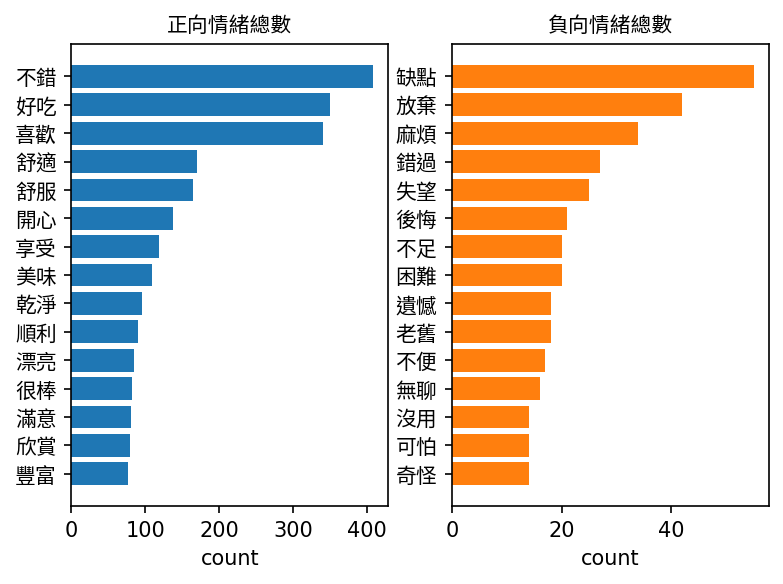

In [117]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

### 重新繪製情緒分數趨勢圖

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

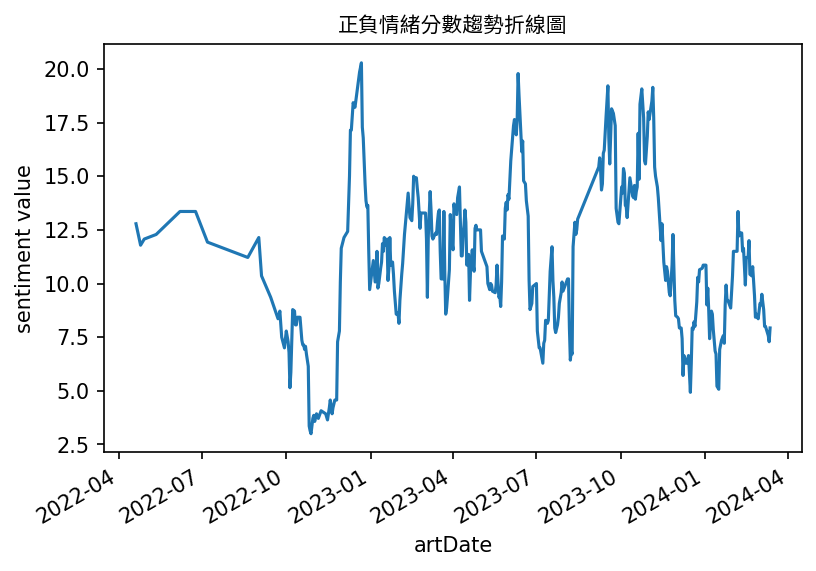

In [118]:
sentiment_count_revise = pd.DataFrame(
    ptt_liwc_df_revise.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative") 
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

### 文字雲
2023-08 ~ 2023-11月情緒分數特別低，來看看這段時間的關鍵字

In [119]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
ptt_liwc_df_revise.head()

artUrl     artDate  \
0  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  2022-01-03   
1  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  2022-01-03   
2  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  2022-01-03   
3  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  2022-01-03   
4  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  2022-01-03   

           artTitle                                         artContent  \
0  [住宿]關西W大阪(WHotel  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
1  [住宿]關西W大阪(WHotel  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
2  [住宿]關西W大阪(WHotel  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
3  [住宿]關西W大阪(WHotel  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
4  [住宿]關西W大阪(WHotel  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   

     word sentiments sentiment_class  
0      新年        NaN              正向  
1      快樂     affect              正向  
2      快樂   positive              正向  
3  212111        NaN              正向  
4      寫完        NaN              正向

In [120]:
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
sent_df.head()

artUrl          artTitle  \
0  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  [住宿]關西W大阪(WHotel   
1  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  [住宿]關西W大阪(WHotel   
2  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  [住宿]關西W大阪(WHotel   
3  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  [住宿]關西W大阪(WHotel   
4  https://www.ptt.cc/bbs/Japan_Travel/M.16411981...  [住宿]關西W大阪(WHotel   

      artDate                                         artContent  \
0  2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
1  2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
2  2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
3  2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   
4  2022-01-03  新年快樂!!!\n\n\n造訪日期：2121.11\n\n從上回寫完佐渡懶人包之後可能精疲力...   

                               sentence sentiment_class  
0                                  新年快樂              正向  
1                            造訪日期212111              正向  
2                    從上回寫完佐渡懶人包之後可能精疲力竭              正向  
3                             超久都沒碰blog              正向  
4  但想說為了維持乾淨版面 每年年費還是有在繳加減也要output一下 XD              正向

In [121]:
date = "2022-09-01"
end_date = "2022-11-30"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask]
ptt_df_wc

artUrl     artDate  \
14431  https://www.ptt.cc/bbs/Japan_Travel/M.16653954...  2022-10-10   
14432  https://www.ptt.cc/bbs/Japan_Travel/M.16653954...  2022-10-10   
14433  https://www.ptt.cc/bbs/Japan_Travel/M.16653954...  2022-10-10   
14434  https://www.ptt.cc/bbs/Japan_Travel/M.16653954...  2022-10-10   
14435  https://www.ptt.cc/bbs/Japan_Travel/M.16653954...  2022-10-10   
...                                                  ...         ...   
19001  https://www.ptt.cc/bbs/Japan_Travel/M.16684922...  2022-11-15   
19002  https://www.ptt.cc/bbs/Japan_Travel/M.16684922...  2022-11-15   
19003  https://www.ptt.cc/bbs/Japan_Travel/M.16684922...  2022-11-15   
19004  https://www.ptt.cc/bbs/Japan_Travel/M.16684922...  2022-11-15   
19005  https://www.ptt.cc/bbs/Japan_Travel/M.16684922...  2022-11-15   

                          artTitle  \
14431          [資訊]日本國定假日2022-2023   
14432          [資訊]日本國定假日2022-2023   
14433          [資訊]日本國定假日2022-2023   
14434          [資訊]日本國定假日2022-2023   
14435          [資訊]日本國定假日2022-2023   
...                            ...   
19001  Re:[住宿]請小心ComfortHotel的刷卡陷阱   
19002  Re:[住宿]請小心ComfortHotel的刷卡陷阱   
19003  Re:[住宿]請小心ComfortHotel的刷卡陷阱   
19004  Re:[住宿]請小心ComfortHotel的刷卡陷阱   
19005  Re:[住宿]請小心ComfortHotel的刷卡陷阱   

                                              artContent word sentiments  \
14431  睽違已久的日旅 規劃的時候建議參考一下日本的國定假日唷\n\n日本人連假出遊的人潮也是很驚人...   睽違        NaN   
14432  睽違已久的日旅 規劃的時候建議參考一下日本的國定假日唷\n\n日本人連假出遊的人潮也是很驚人...   已久        NaN   
14433  睽違已久的日旅 規劃的時候建議參考一下日本的國定假日唷\n\n日本人連假出遊的人潮也是很驚人...   規劃        NaN   
14434  睽違已久的日旅 規劃的時候建議參考一下日本的國定假日唷\n\n日本人連假出遊的人潮也是很驚人...   參考        NaN   
14435  睽違已久的日旅 規劃的時候建議參考一下日本的國定假日唷\n\n日本人連假出遊的人潮也是很驚人...   日本        NaN   
...                                                  ...  ...        ...   
19001  啊....這個我\n2018年三月\n寫在本板的文章就有提到過了。\n#1QgbnXwd\n...   日元        NaN   
19002  啊....這個我\n2018年三月\n寫在本板的文章就有提到過了。\n#1QgbnXwd\n...   結帳        NaN   
19003  啊....這個我\n2018年三月\n寫在本板的文章就有提到過了。\n#1QgbnXwd\n...   店員        NaN   
19004  啊....這個我\n2018年三月\n寫在本板的文章就有提到過了。\n#1QgbnXwd\n...   稍微        NaN   
19005  啊....這個我\n2018年三月\n寫在本板的文章就有提到過了。\n#1QgbnXwd\n...  YES        NaN   

      sentiment_class  
14431              負向  
14432              負向  
14433              負向  
14434              負向  
14435              負向  
...               ...  
19001              負向  
19002              負向  
19003              負向  
19004              負向  
19005              負向  

[690 rows x 7 columns]

In [122]:
date = "2022-09-01"
end_date = "2022-11-30"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

word  size
242   日本    11
448   颱風     9
209   拉麵     9
228   支付     9
129   台幣     7
..   ...   ...
230   改期     1
229   改到     1
75    付菜     1
226   搞定     1
232   文章     1

[464 rows x 2 columns]

(-0.5, 399.5, 199.5, -0.5)

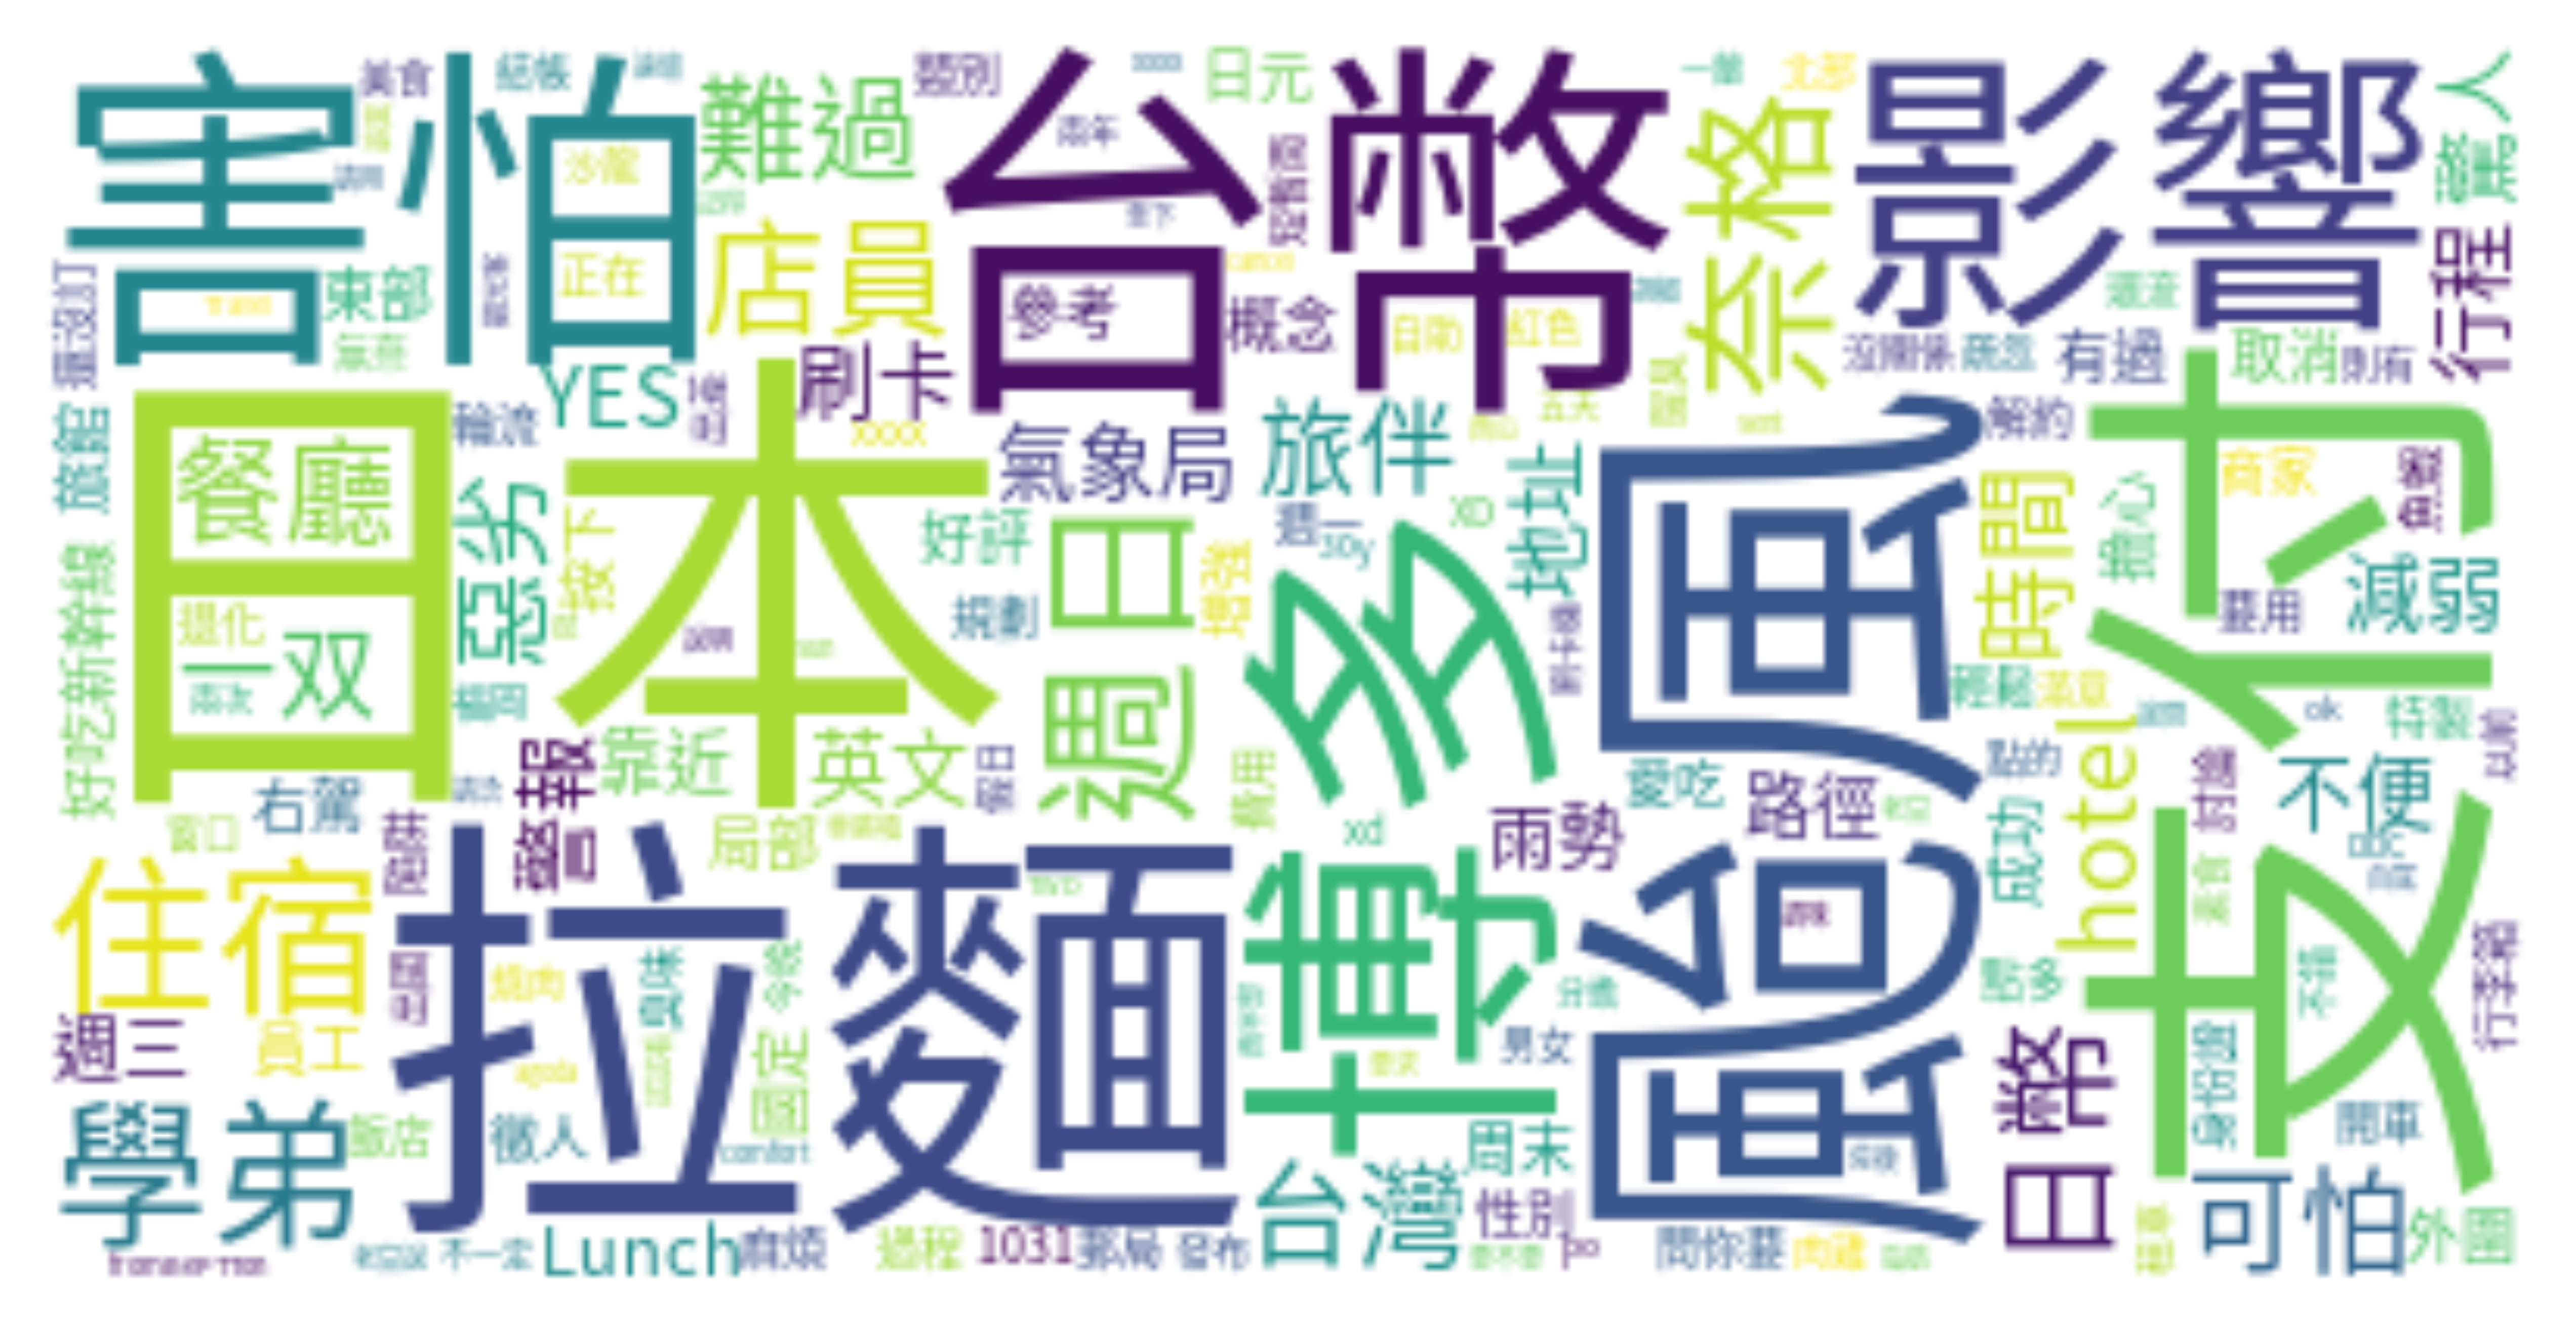

In [123]:
# wordcloud 的 input 是 dictionary
font_path = "SourceHanSansTW-Regular.otf"  # 中文字型路徑
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=800)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

<font color=#ffa>從文字雲可以看出這段時間似乎有颱風侵襲日本，因此去查看內文含有颱風的負面字詞</font>

(-0.5, 399.5, 199.5, -0.5)

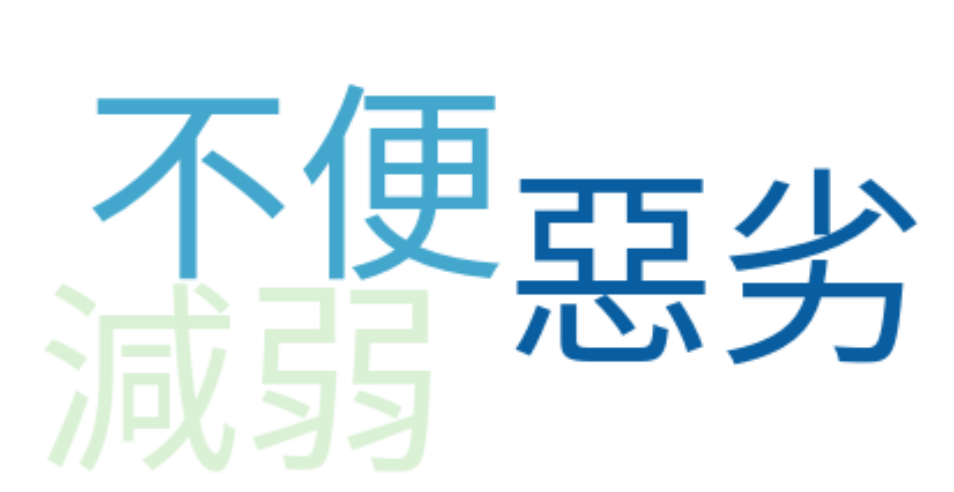

In [124]:
date = "2022-09-01"
end_date = "2022-11-30"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    ptt_liwc_df_revise['sentiment_class'] == "負向")  & ( # 負面文章
    ptt_liwc_df_revise['artContent'].str.contains('颱風')) & ( # 內文包含颱風
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
font_path = "SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

<font color=#ffa>查看句字中含有 "不便" 的句子 </font>

In [125]:
date = "2022-09-01"
end_date = "2022-11-30"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('颱風')) & (
    sent_df['sentence'].str.contains('不便')) # 包含「不便」的句子

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df

artUrl  \
3687  https://www.ptt.cc/bbs/Japan_Travel/M.16668680...   
3688  https://www.ptt.cc/bbs/Japan_Travel/M.16668680...   
3689  https://www.ptt.cc/bbs/Japan_Travel/M.16668680...   
3690  https://www.ptt.cc/bbs/Japan_Travel/M.16668680...   
3691  https://www.ptt.cc/bbs/Japan_Travel/M.16668680...   
3692  https://www.ptt.cc/bbs/Japan_Travel/M.16668680...   
3693  https://www.ptt.cc/bbs/Japan_Travel/M.16668680...   
3694  https://www.ptt.cc/bbs/Japan_Travel/M.16669251...   
3695  https://www.ptt.cc/bbs/Japan_Travel/M.16669251...   
3696  https://www.ptt.cc/bbs/Japan_Travel/M.16669251...   
3697  https://www.ptt.cc/bbs/Japan_Travel/M.16669251...   

                            artTitle     artDate  \
3687         [資訊]颱風週末靠近恐海陸警雙響　路徑變數大北  2022-10-27   
3688         [資訊]颱風週末靠近恐海陸警雙響　路徑變數大北  2022-10-27   
3689         [資訊]颱風週末靠近恐海陸警雙響　路徑變數大北  2022-10-27   
3690         [資訊]颱風週末靠近恐海陸警雙響　路徑變數大北  2022-10-27   
3691         [資訊]颱風週末靠近恐海陸警雙響　路徑變數大北  2022-10-27   
3692         [資訊]颱風週末靠近恐海陸警雙響　路徑變數大北  2022-10-27   
3693         [資訊]颱風週末靠近恐海陸警雙響　路徑變數大北  2022-10-27   
3694  Re:[徵人][旅伴]12/20或12/21北海道美瑛一日遊  2022-10-28   
3695  Re:[徵人][旅伴]12/20或12/21北海道美瑛一日遊  2022-10-28   
3696  Re:[徵人][旅伴]12/20或12/21北海道美瑛一日遊  2022-10-28   
3697  Re:[徵人][旅伴]12/20或12/21北海道美瑛一日遊  2022-10-28   

                                             artContent  \
3687  https://reurl.cc/GXZ7Np\n編輯：李家穎 ｜ 2022-10-27　1...   
3688  https://reurl.cc/GXZ7Np\n編輯：李家穎 ｜ 2022-10-27　1...   
3689  https://reurl.cc/GXZ7Np\n編輯：李家穎 ｜ 2022-10-27　1...   
3690  https://reurl.cc/GXZ7Np\n編輯：李家穎 ｜ 2022-10-27　1...   
3691  https://reurl.cc/GXZ7Np\n編輯：李家穎 ｜ 2022-10-27　1...   
3692  https://reurl.cc/GXZ7Np\n編輯：李家穎 ｜ 2022-10-27　1...   
3693  https://reurl.cc/GXZ7Np\n編輯：李家穎 ｜ 2022-10-27　1...   
3694  預計在北海道旅遊五天，\n機票已買好12/18-22，目前有兩位女生\n12/19 安排從札...   
3695  預計在北海道旅遊五天，\n機票已買好12/18-22，目前有兩位女生\n12/19 安排從札...   
3696  預計在北海道旅遊五天，\n機票已買好12/18-22，目前有兩位女生\n12/19 安排從札...   
3697  預計在北海道旅遊五天，\n機票已買好12/18-22，目前有兩位女生\n12/19 安排從札...   

                                               sentence sentiment_class  
3687                                             週日至下週三              負向  
3688                             如有安排野外活動如登山戲水等盡可能避免或改期              負向  
3689                                         因為天候將會相當惡劣              負向  
3690                                              具有高風險              負向  
3691     如果颱風真如這則新聞所說的路徑走那麼影響最大的應該是1031111這兩天好死不死我剛好...              負向  
3692                                依舊沒有適合的不便險可以保只能打水漂了              負向  
3693             Sent fromBePTTon my iPhone 13 Pro Max               負向  
3694                                         預計在北海道旅遊五天              正向  
3695                                        機票已買好121822              正向  
3696                             目前有兩位女生1219 安排從札幌包車去美瑛              正向  
3697                                 包車行程安排如下美瑛一日遊目前是3位              正向

### <font color=#ffa>結果顯示，日本在那段期間確實有遭到颱風的侵襲，導致旅遊不便</font>